In [1]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from statistic import *
from heart import heart
from valve_p import ValveinP
from three_windkessel import PressureSystem
from SALib.sample import sobol_sequence
from SALib.sample import sobol
from tqdm import tqdm 
sens = sensitivity()
T=60/75
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)

av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc

mv=ValveinP(density = 1.06,eff_length = 1.25,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc

cap_s=PressureSystem(0.0008, 90, 1200)#C,Za,R

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T) # Ks, V0, T

tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1.9,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc
t_end=15
t = [0,t_end]
t_step = 0.01
t_span=np.arange(0,t_end,t_step)
index_range = slice(1320, 1400)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy
rvef_param = []
lvef_param = []
sv_lv_param = []
sv_rv_param = []
p_lv_param_list = []
p_rv_param_list = []
p_pa_param_list = []
p_ao_param_list = []
v_lv_param_statistic = []
v_rv_param_statistic = []

problem = {
    'num_vars': 3,
    'names': ['Za', 'R','C'],
    'bounds': [[10, 200], [50, 200],[0.0005,0.002]]
}
param_values = sobol.sample(problem, 256) 

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
for param in tqdm(param_values):
    Za = param[0]
    R = param[1]
    C = param[2]
    cap_p=PressureSystem(C, Za, R)#C,Za,R
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_rv = []
    p_ao = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ao.append(cap_p.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_lv.append(lv.p(v_lv[j],i))
    max_rv = max(sol.y[7][index_range])
    min_rv = min(sol.y[7][index_range])
    max_lv = max(sol.y[0][index_range])
    min_lv = min(sol.y[0][index_range])
    sv_rv_param.append(max_rv-min_rv)
    sv_lv_param.append(max_lv-min_lv)
    rvef_param.append(sv_rv_param[-1]/max_rv)
    lvef_param.append(sv_lv_param[-1]/max_lv)
    
    p_lv_param = list(map(lambda x: x / 1333, p_lv))
    p_lv_param_list.append(p_lv_param)
    
    p_rv_param = list(map(lambda x: x / 1333, p_rv))
    p_rv_param_list.append(p_rv_param)
    
    p_pa_param = list(map(lambda x: x / 1333, p_pa))
    p_pa_param_list.append(p_pa_param)
    
    p_ao_param = list(map(lambda x: x / 1333, p_ao))
    p_ao_param_list.append(p_ao_param)
    
    v_lv_param_statistic.append(v_lv)
    v_rv_param_statistic.append(v_rv)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [44:12<00:00,  1.30s/it]


In [3]:
p_lv_param_list = np.array(p_lv_param_list)
p_rv_param_list = np.array(p_rv_param_list)
p_pa_param_list = np.array(p_pa_param_list)
p_ao_param_list = np.array(p_ao_param_list)
v_lv_param_statistic = np.array(v_lv_param_statistic)
v_rv_param_statistic = np.array(v_rv_param_statistic)
sv_rv_param = np.array(sv_rv_param)
sv_lv_param = np.array(sv_lv_param)
rvef_param = np.array(rvef_param)
lvef_param = np.array(lvef_param)

In [4]:
n=len(p_lv_param_list)
p_lv_param_time = p_lv_param_list.T
p_rv_param_time = p_rv_param_list.T
p_pa_param_time = p_pa_param_list.T
p_ao_param_time = p_ao_param_list.T
v_rv_param_time = v_lv_param_statistic.T
v_lv_param_time = v_rv_param_statistic.T

In [5]:
p_lv_param_time_slice = p_lv_param_time[index_range]
p_rv_param_time_slice = p_rv_param_time[index_range]
p_pa_param_time_slice = p_pa_param_time[index_range]
p_ao_param_time_slice = p_ao_param_time[index_range]
v_rv_param_time_slice = v_rv_param_time[index_range]
v_lv_param_time_slice = v_lv_param_time[index_range]

In [6]:
S1_p_lv = []
S1_p_rv = []
S1_p_pa_param_list = []
S1_p_ao_param_list = []
S1_v_rv_param_statistic = []
S1_v_lv_param_statistic = []
ST_p_lv = []
ST_p_rv = []
ST_p_pa_param_list = []
ST_p_ao_param_list = []
ST_v_rv_param_statistic = []
ST_v_lv_param_statistic = []
S1_sv_rv_param = []
S1_sv_lv_param = []
S1_rvef_param = []
S1_lvef_param = []
ST_sv_rv_param = []
ST_sv_lv_param = []
ST_rvef_param = []
ST_lvef_param = []

In [7]:
from SALib.analyze import sobol
count = range(0,index_range.stop-index_range.start)
for j in tqdm(count):
    #print(j)
    S1_p_lv.append(sobol.analyze(problem, p_lv_param_time_slice[j])['S1'])
    S1_p_rv.append(sobol.analyze(problem, p_rv_param_time_slice[j])['S1'])
    S1_p_pa_param_list.append(sobol.analyze(problem, p_pa_param_time_slice[j])['S1'])
    S1_p_ao_param_list.append(sobol.analyze(problem, p_ao_param_time_slice[j])['S1'])
    S1_v_rv_param_statistic.append(sobol.analyze(problem, v_rv_param_time_slice[j])['S1'])
    S1_v_lv_param_statistic.append(sobol.analyze(problem, v_lv_param_time_slice[j])['S1'])
    ST_p_lv.append(sobol.analyze(problem, p_lv_param_time_slice[j])['ST'])
    ST_p_rv.append(sobol.analyze(problem, p_rv_param_time_slice[j])['ST'])
    ST_p_pa_param_list.append(sobol.analyze(problem, p_pa_param_time_slice[j])['ST'])
    ST_p_ao_param_list.append(sobol.analyze(problem, p_ao_param_time_slice[j])['ST'])
    ST_v_rv_param_statistic.append(sobol.analyze(problem, v_rv_param_time_slice[j])['ST'])
    ST_v_lv_param_statistic.append(sobol.analyze(problem, v_lv_param_time_slice[j])['ST'])

  0%|                                                                                                                                                                                                                                   | 0/80 [00:00<?, ?it/s]/home/shiting/.local/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:07<00:00, 11.40it/s]


In [8]:
S1_sv_rv_param = sobol.analyze(problem, sv_rv_param)['S1']
ST_sv_rv_param = sobol.analyze(problem, sv_rv_param)['ST']
S1_sv_lv_param = sobol.analyze(problem, sv_lv_param)['S1']
ST_sv_lv_param = sobol.analyze(problem, sv_lv_param)['ST']
S1_rvef_param = sobol.analyze(problem, rvef_param)['S1']
ST_rvef_param = sobol.analyze(problem, rvef_param)['ST']
S1_lvef_param = sobol.analyze(problem, lvef_param)['S1']
ST_lvef_param = sobol.analyze(problem, lvef_param)['ST']

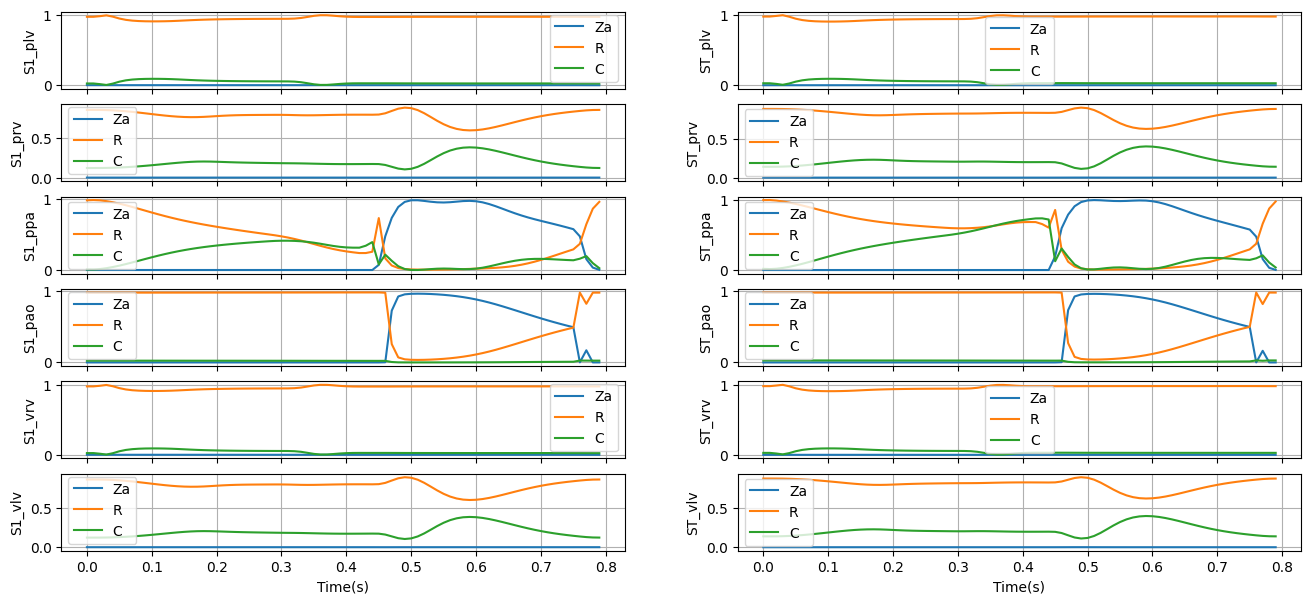

In [11]:
time = np.arange(0,0.8,0.01)
label = ['Za','R','C']
fig, axs = plt.subplots(6, 2, figsize=(16, 7),sharex=True) 
axs[0,0].plot(time, S1_p_lv, label =label)
axs[0,0].set_ylabel('S1_plv')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].plot(time,ST_p_lv,label=label)
axs[0,1].set_ylabel('ST_plv')
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(time, S1_p_rv, label =label)
axs[1,0].set_ylabel('S1_prv')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(time,ST_p_rv,label=label)
axs[1,1].set_ylabel('ST_prv')
axs[1,1].grid()
axs[1,1].legend()

axs[2,0].plot(time, S1_p_pa_param_list, label =label)
axs[2,0].set_ylabel('S1_ppa')
axs[2,0].legend()
axs[2,0].grid()

axs[2,1].plot(time,ST_p_pa_param_list,label=label)
axs[2,1].set_ylabel('ST_ppa')
axs[2,1].grid()
axs[2,1].legend()

axs[3,0].plot(time, S1_p_ao_param_list, label =label)
axs[3,0].set_ylabel('S1_pao')
axs[3,0].legend()
axs[3,0].grid()

axs[3,1].plot(time,ST_p_ao_param_list,label=label)
axs[3,1].set_ylabel('ST_pao')
axs[3,1].grid()
axs[3,1].legend()

axs[4,0].plot(time, S1_v_rv_param_statistic, label =label)
axs[4,0].set_ylabel('S1_vrv')
axs[4,0].legend()
axs[4,0].grid()

axs[4,1].plot(time,ST_v_rv_param_statistic,label=label)
axs[4,1].set_ylabel('ST_vrv')
axs[4,1].grid()
axs[4,1].legend()

axs[5,0].plot(time, S1_v_lv_param_statistic, label =label)
axs[5,0].set_ylabel('S1_vlv')
axs[5,0].legend()
axs[5,0].grid()
axs[5,0].set_xlabel('Time(s)')
axs[5,1].plot(time,ST_v_lv_param_statistic,label=label)
axs[5,1].set_ylabel('ST_vlv')
axs[5,1].grid()
axs[5,1].legend()
axs[5,1].set_xlabel('Time(s)')
#plt.savefig('global_sensitivity.svg')
plt.show()


In [14]:
print('S1_svrv',S1_sv_rv_param)
print('ST_svrv',ST_sv_rv_param)
print('S1_svlv',S1_sv_lv_param)
print('ST_svlv',ST_sv_lv_param)
print('S1_rvef',S1_rvef_param)
print('ST_rvef',ST_rvef_param)
print('S1_lvef',S1_lvef_param)
print('ST_lvef',ST_lvef_param)

S1_svrv [-2.38969313e-05  9.68106483e-01  2.99837828e-02]
ST_svrv [9.97646053e-06 9.76067365e-01 3.36854228e-02]
S1_svlv [-1.00954707e-04  9.69611321e-01  2.81723998e-02]
ST_svlv [8.25199571e-06 9.77034468e-01 3.19207233e-02]
S1_rvef [-4.95461063e-05  9.07454722e-01  8.71334076e-02]
ST_rvef [1.59671293e-06 9.20020806e-01 9.44736033e-02]
S1_lvef [1.04873874e-04 9.49368901e-01 4.51060677e-02]
ST_lvef [5.67416210e-05 9.60544046e-01 5.13077974e-02]


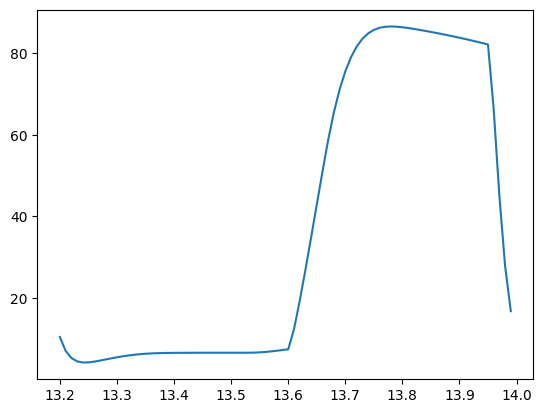

In [35]:
plt.plot(sol.t[1320:1400],p_lv_param_list[0][1320:1400])
plt.show()

In [34]:
p_lv_param_list

array([[10.        , 16.130151  , 24.78336517, ...,  6.42228404,
         6.460068  ,  6.48574874],
       [10.        , 16.13015533, 24.78337472, ...,  6.42182666,
         6.45960955,  6.48529977],
       [10.        , 16.13013837, 24.78332034, ...,  7.28411327,
         7.32491609,  7.35219375],
       ...,
       [10.        , 16.13015768, 24.78337015, ...,  7.12428594,
         7.16456031,  7.19157774],
       [10.        , 16.13015831, 24.78337781, ...,  6.17950111,
         6.22241579,  6.25264667],
       [10.        , 16.130166  , 24.78339496, ...,  6.45406564,
         6.49238078,  6.51845732]])